<a href="https://colab.research.google.com/github/blancavazquez/Escuela_Invierno2025/blob/main/notebooks/P3_Transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Taller: Visión computacional e IA (parte 3)

El objetivo de esta libreta es segmentar objetos usando un modelo previamente pre-entrenado.


## Aprendizaje por transferencia


El aprendizaje por transferencia (transfer learning) es un método de aprendizaje automático que consiste en que un modelo entrenado para una tarea es reutilizado com punto de partida para realizar otra tarea.

![Alt text](https://www.pinecone.io/_next/image/?url=https%3A%2F%2Fcdn.sanity.io%2Fimages%2Fvr8gru94%2Fproduction%2Fdb540542eb64f3f9fe39847f283249f0701a8b2b-1200x613.png&w=1200&q=75 "Comparativa general de la transferencia de conocimientos y el aprendizaje de máquinas")

Imagen tomada de [datascience.aero](https://datascience.aero/)

## Ventajas del aprendizaje por transferencia




*   Reducción del costo computacional
*   No dependencia de grandes conjuntos de datos necesarios para el entrenamiento
* Aumento en la generalización del modelo
* Mejora en el rendimiento





![Alt text](https://www.pinecone.io/_next/image/?url=https%3A%2F%2Fcdn.sanity.io%2Fimages%2Fvr8gru94%2Fproduction%2Feef85e11a9f57337cfbe60c4aced72fe074b9f18-1098x542.png&w=1200&q=75 "Sin aprendizaje por transferencia vs con aprendizaje por transferencia")

Imagen tomada de [Machine Learning Mastery](https://machinelearningmastery.com/transfer-learning-for-deep-learning/)



---



## Descripción de la base de datos pre-entrenada


El modelo usado fue entrenado con la base de datos de ["PASCAL VOC (PASCAL Visual Object Classes Challenge)"](http://host.robots.ox.ac.uk/pascal/VOC/).


Pascal VOC (por las siglas de Pattern Analysis, Statistical Modelling, and Computational Learning Visual Object Classes) es un conjunto de datos de imágenes de código abierto usando en tareas de reconocimiento de objetos visuales. Este conjunto de datos tiene 20 clases y ha sido utilizado en tareas de: clasificación, detección y segmentación.


![Alt text](https://viso.ai/wp-content/smush-webp/2024/05/Pascal-Visual-Object-Class-Categories-768x366.jpg.webp "Categorías de imágenes en PASCAL VOC")



![Alt text](https://viso.ai/wp-content/smush-webp/2024/05/Visual-Object-Classification-Using-Pascal-VOC-Dataset-768x557.jpg.webp "Categorías de imágenes en PASCAL VOC")


Para mayor información:


* [Pascal VOC Dataset: A Technical Deep Dive (2025 Guide)](https://viso.ai/deep-learning/pascal-voc-dataset/)
*   [Paperswithcode](https://paperswithcode.com/dataset/pascal-voc)
*   [Location-aware Single Image Reflection Removal](https://arxiv.org/pdf/2012.07131v2)
* [PASCAL VOC2011 Example Images](http://host.robots.ox.ac.uk/pascal/VOC/voc2011/examples/index.html)



---



## Paso 1: Conexión con Google Drive, instalación y carga de bibliotecas

In [ ]:
# Conexión con Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
! ls
%cd /content/drive/MyDrive/

'1 IIMAS Mérida'
 2024_Renovación_Blanca
 Classroom
'Colab Notebooks'
 CV
 Escuela_Invierno2025
'Formulario para registrar charlas o talleres: 8ta Escuela de Invierno.gform'
'IIMAS CU'
 Personal
 PostDoc_2023
 SNI
/content/drive/MyDrive


In [ ]:
!pip install lightning

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms, models
from PIL import Image

import torch
from torchvision import transforms, datasets, models
import lightning as L

## Paso 2: Instanciando modelo

In [ ]:
class LitSegmentation(L.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = models.segmentation.fcn_resnet50(num_classes=21)
        self.loss_fn = torch.nn.CrossEntropyLoss()

    def training_step(self, batch):
        images, targets = batch
        outputs = self.model(images)['out']
        loss = self.loss_fn(outputs, targets.long().squeeze(1))
        self.log("train_loss", loss)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=0.01)

class SegmentationData(L.LightningDataModule):
    def prepare_data(self):
        datasets.VOCSegmentation(root="data", download=True)

    def train_dataloader(self):
        transform = transforms.Compose([transforms.ToTensor(),
                                        transforms.Resize((256, 256)),
                                        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                                        ])
        target_transform = transforms.Compose([transforms.ToTensor(), transforms.Resize((256, 256))])
        train_dataset = datasets.VOCSegmentation(root="data", transform=transform, target_transform=target_transform)
        return torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2)

In [ ]:
# Definición de los colores para segmentar objetivos (definidos en PASCAL VOC)
VOC_COLORMAP = np.array(
    [
        [0, 0, 0],  # Background
        [128, 0, 0],  # Aeroplane
        [0, 128, 0],  # Bicycle
        [128, 128, 0],  # Bird
        [0, 0, 128],  # Boat
        [128, 0, 128],  # Bottle
        [0, 128, 128],  # Bus
        [128, 128, 128],  # Car
        [64, 0, 0],  # Cat
        [192, 0, 0],  # Chair
        [64, 128, 0],  # Cow
        [192, 128, 0],  # Dining table
        [64, 0, 128],  # Dog
        [192, 0, 128],  # Horse
        [64, 128, 128],  # Motorbike
        [192, 128, 128],  # Person
        [0, 64, 0],  # Potted plant
        [128, 64, 0],  # Sheep
        [0, 192, 0],  # Sofa
        [128, 192, 0],  # Train
        [0, 64, 128],  # TV/Monitor
    ]
)

def voc_colormap2label():
    """Create a colormap to label mapping for Pascal VOC."""
    colormap2label = np.zeros(256**3, dtype=np.uint8)
    for i, colormap in enumerate(VOC_COLORMAP):
        colormap2label[(colormap[0] * 256 + colormap[1]) * 256 + colormap[2]] = i
    return colormap2label

def label2image(pred):
    """Convertir etiqueta a mapa de color"""
    colormap = VOC_COLORMAP[pred]
    return colormap.astype(np.uint8)

### Paso 3: Carga del modelo pre-entrenado

In [ ]:
# En caso de entrenar el modelo desde cero, debe indicarse la ruta en donde el modelo está almacenado
checkpoint_path = None
if checkpoint_path is not None:
    model = LitSegmentation.load_from_checkpoint(checkpoint_path)

#En caso contrario, se usarán los pesos del modelo ya entrenado
else:
    model = LitSegmentation()
    model.model = models.segmentation.fcn_resnet50(num_classes=21, weights=models.segmentation.FCN_ResNet50_Weights.DEFAULT)
model.eval()

LitSegmentation(
  (model): FCN(
    (backbone): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (

### Paso 4: Evaluando al modelo

In [ ]:
#Mapeo de colores a etiqueta
colormap2label = voc_colormap2label()

# Cargando imagen de entrada
input_image_path = "Escuela_Invierno2025/data/multiples_cars.jpeg"
#multiples_cars.jpeg, Velomobile.jpg, bike_car.jpg, 6ta_escuela.png

# Procesando imagen de entrada
input_image = Image.open(input_image_path).convert("RGB")
preprocess = transforms.Compose([transforms.Resize((256, 256)),
                                 transforms.ToTensor(),
                                 transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                                 ])
input_tensor = preprocess(input_image)#.unsqueeze(0)  # Add batch dimension
input_tensor = torch.unsqueeze(input_tensor, 0)

### Paso 5: Predicción

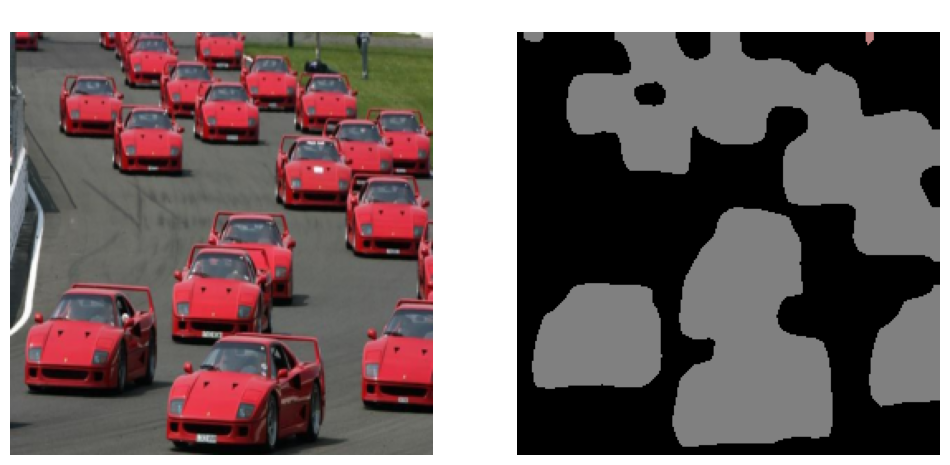

<Figure size 640x480 with 0 Axes>

In [ ]:
with torch.no_grad():
    output = model.model(input_tensor)["out"]
pred = torch.argmax(output.squeeze(), dim=0).cpu().numpy()

# Conversión de etiqueta a imagen
pred_colored = label2image(pred)

# Visualizando la imagen original y la segmentación
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Imagen original
axs[0].imshow(transforms.Resize((256, 256))(input_image))
axs[0].set_title("Imagen de entrada", color="white")
axs[0].axis("off")

# Segmentación generada
axs[1].imshow(pred_colored)
axs[1].set_title("Resultado: segmentación", color="white")
axs[1].axis("off")

plt.show()
plt.gcf().set_facecolor("black")